In [1]:
import os
import pandas as pd
import sqlalchemy as db
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
os.chdir('C:\\____michal\\dtscnc\\kaggle\\soccer')

In [3]:
os.listdir()

['database.sqlite']

In [4]:
engine = db.create_engine('sqlite:///database.sqlite')

In [5]:
engine.table_names()

['Country',
 'League',
 'Match',
 'Player',
 'Player_Attributes',
 'Team',
 'Team_Attributes',
 'sqlite_sequence']

In [6]:
country = pd.read_sql_query("SELECT * FROM Country", engine)

In [7]:
league = pd.read_sql_query("SELECT * FROM League", engine)

In [8]:
soccer = pd.merge(country, league, how = 'inner', on = 'id')

In [9]:
soccer.columns = ['id', 'country_name', 'country_id', 'league_name']

In [10]:
soccer = soccer.drop('id', axis = 1)

In [11]:
soccer

,country_name,country_id,league_name
0,Belgium,1,Belgium Jupiler League
1,England,1729,England Premier League
2,France,4769,France Ligue 1
3,Germany,7809,Germany 1. Bundesliga
4,Italy,10257,Italy Serie A
5,Netherlands,13274,Netherlands Eredivisie
6,Poland,15722,Poland Ekstraklasa
7,Portugal,17642,Portugal Liga ZON Sagres
8,Scotland,19694,Scotland Premier League
9,Spain,21518,Spain LIGA BBVA


In [12]:
team = pd.read_sql_query("SELECT * FROM Team", engine)

In [13]:
team.shape

(299, 5)

In [14]:
team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [15]:
match = pd.read_sql_query("SELECT * FROM Match", engine)

In [16]:
match.shape

(25979, 115)

In [17]:
match = pd.merge(match, team[['team_api_id','team_long_name']], how = 'inner', left_on = 'home_team_api_id', right_on = 'team_api_id')


In [18]:
match = match.rename(columns = {'team_long_name':'home_team_name'})

In [19]:
match = pd.merge(match, team[['team_api_id','team_long_name']], how = 'inner', left_on = 'away_team_api_id', right_on = 'team_api_id')

In [20]:
match = match.rename(columns = {'team_long_name':'away_team_name'})

In [21]:
match_short = match[['id', 'country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id',
 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'home_team_name', 'away_team_name']]

In [22]:
match_short.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_name,away_team_name
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,KRC Genk,Beerschot AC
1,483,1,1,2009/2010,5,2009-08-30 00:00:00,665353,9987,9993,1,1,KRC Genk,Beerschot AC
2,524,1,1,2010/2011,1,2010-08-01 00:00:00,838476,9987,9993,2,1,KRC Genk,Beerschot AC
3,759,1,1,2011/2012,1,2011-07-30 00:00:00,1032694,9987,9993,3,1,KRC Genk,Beerschot AC
4,1014,1,1,2012/2013,11,2012-10-20 00:00:00,1224064,9987,9993,3,0,KRC Genk,Beerschot AC


In [23]:
match_short = match_short.merge(soccer, how = 'inner', on = 'country_id')

In [24]:
match_short.drop('league_id', axis = 1, inplace = True)

In [25]:
def result(score):
    if score > 0:
        return 'home wins'
    elif score < 0:
        return 'away wins'
    else:
        return 'tie'

In [26]:
match_short['result'] = (match_short['home_team_goal'] - match_short['away_team_goal']).apply(lambda x: result(x))

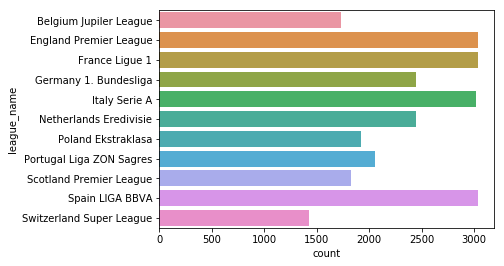

In [28]:
sns.countplot(y = 'league_name', data = match_short)

In [32]:
match_short['result'] = pd.Categorical(match_short['result'], ordered = True, categories = ['home wins', 'away wins', 'tie'])

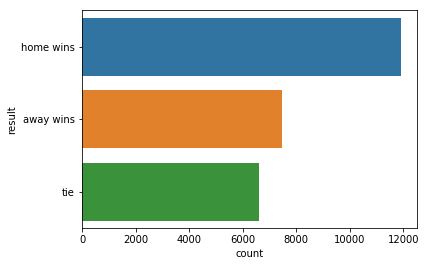

In [35]:
sns.countplot(y = 'result', data = match_short)

In [40]:
#get the percentage of each result for each league
match_short.groupby(['league_name', 'result']).agg({'result':'count'}) / match_short.groupby(['league_name']).agg({'result':'count'})*100


result
league_name              result              
Belgium Jupiler League   home wins  46.875000
                         away wins  28.530093
                         tie        24.594907
England Premier League   home wins  45.723684
                         away wins  28.519737
                         tie        25.756579
France Ligue 1           home wins  44.703947
                         away wins  27.039474
                         tie        28.256579
Germany 1. Bundesliga    home wins  45.220588
                         away wins  30.392157
                         tie        24.387255
Italy Serie A            home wins  46.635731
                         away wins  26.980444
                         tie        26.383825
Netherlands Eredivisie   home wins  47.834967
                         away wins  28.431373
                         tie        23.733660
Poland Ekstraklasa       home wins  45.312500
                         away wins  27.343750
                         tie        27.343750
Portugal Liga ZON Sagres home wins  44.249513
                         away wins  29.775828
                         tie        25.974659
Scotland Premier League  home wins  41.666667
                         away wins  33.826754
                         tie        24.506579
Spain LIGA BBVA          home wins  48.848684
                         away wins  27.993421
                         tie        23.157895
Switzerland Super League home wins  45.710267
                         away wins  29.957806
                         tie        24.331927

In [55]:
grp = match_short.groupby(['league_name', 'result']).agg({'result':'count'}) / match_short.groupby(['league_name']).agg({'result':'count'})*100

In [58]:
grp.index.levels

FrozenList([['Belgium Jupiler League', 'England Premier League', 'France Ligue 1', 'Germany 1. Bundesliga', 'Italy Serie A', 'Netherlands Eredivisie', 'Poland Ekstraklasa', 'Portugal Liga ZON Sagres', 'Scotland Premier League', 'Spain LIGA BBVA', 'Switzerland Super League'], ['home wins', 'away wins', 'tie']])

In [79]:
for i in grp.index:
    print(i[0], i[1])

Belgium Jupiler League home wins
Belgium Jupiler League away wins
Belgium Jupiler League tie
England Premier League home wins
England Premier League away wins
England Premier League tie
France Ligue 1 home wins
France Ligue 1 away wins
France Ligue 1 tie
Germany 1. Bundesliga home wins
Germany 1. Bundesliga away wins
Germany 1. Bundesliga tie
Italy Serie A home wins
Italy Serie A away wins
Italy Serie A tie
Netherlands Eredivisie home wins
Netherlands Eredivisie away wins
Netherlands Eredivisie tie
Poland Ekstraklasa home wins
Poland Ekstraklasa away wins
Poland Ekstraklasa tie
Portugal Liga ZON Sagres home wins
Portugal Liga ZON Sagres away wins
Portugal Liga ZON Sagres tie
Scotland Premier League home wins
Scotland Premier League away wins
Scotland Premier League tie
Spain LIGA BBVA home wins
Spain LIGA BBVA away wins
Spain LIGA BBVA tie
Switzerland Super League home wins
Switzerland Super League away wins
Switzerland Super League tie


In [113]:
#access the value of ties in Belgian league
grp.loc['Belgium Jupiler League', 'tie'][0]

24.59490740740741

In [114]:
# create a column with the grouped results
for league in match_short['league_name'].unique():
    for result in match_short['result'].unique():
        match_short.loc[(match_short['league_name'] == league) & (match_short['result'] == result), 'share'] = grp.loc[league, result][0]

In [118]:
match_short.head()

,id,country_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_team_name,away_team_name,country_name,league_name,result,share
0,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,KRC Genk,Beerschot AC,Belgium,Belgium Jupiler League,tie,24.594907
1,483,1,2009/2010,5,2009-08-30 00:00:00,665353,9987,9993,1,1,KRC Genk,Beerschot AC,Belgium,Belgium Jupiler League,tie,24.594907
2,524,1,2010/2011,1,2010-08-01 00:00:00,838476,9987,9993,2,1,KRC Genk,Beerschot AC,Belgium,Belgium Jupiler League,home wins,46.875000
3,759,1,2011/2012,1,2011-07-30 00:00:00,1032694,9987,9993,3,1,KRC Genk,Beerschot AC,Belgium,Belgium Jupiler League,home wins,46.875000
4,1014,1,2012/2013,11,2012-10-20 00:00:00,1224064,9987,9993,3,0,KRC Genk,Beerschot AC,Belgium,Belgium Jupiler League,home wins,46.875000


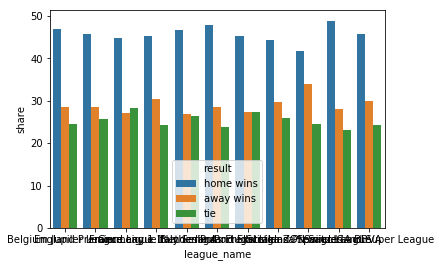

In [120]:
sns.barplot(x = 'league_name', y = 'share', hue = 'result', data = match_short)

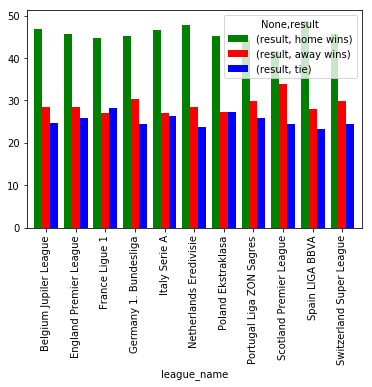

In [89]:
grp.unstack(level = 1).plot(kind = 'bar', width = 0.8, color = ['g', 'r', 'b'])